# Cool-Flame Chemistry:
## Oscillatory combustion of *n*-heptane in a perfectly stirred reactor

This model uses a zero-dimensional reactor, together with a MassFlowController,
 a PressureController, and inlet/outlet reservoirs to simulate a perfectly stirred,
 constant-pressure reactor.

This model is set up to demonstrate oscillatory combustion of a stoichiometric
 *n*-heptane/air mixture. The reactor is "lit" by initializing the state with gas
 at post-first-stage igntion conditions. As it evolves through time, the reactor
 shows oscillatory ignition-extinction-refresh gas cycles.

Feel free to play around and see how different conditions (residence time, fuels,
 equivalence ratios, etc.) affect the reactor behavior.

Adapted from: https://cantera.org/examples/python/reactors/combustor.py.html
Prepared in current form by: Adam Susa (asusa@stanford.edu)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cantera as ct
import os.path

import userdefined as ud

In [2]:
gas = ct.Solution(os.path.abspath('../mechanisms/LLNL_gasoline_red323.cti'))

In [3]:
T = 650
P = 10 * ct.one_atm
phi = 1.
fuel = {'NC7H16':1}
ox = {'O2':1.0, 'N2':3.76}

# Create a Reservoir for the inlet, set to a methane/air mixture at a specified
# equivalence ratio
gas.TP = T, P
gas.set_equivalence_ratio(phi=phi, fuel=fuel, oxidizer=ox)
inlet = ct.Reservoir(gas)

TPX_inlet = gas.TPX

In [4]:
# run a zero-D simulation to determine the 1st-stage IDT
gas.TPX = TPX_inlet
r1 = ct.ConstPressureReactor(gas)
rnet = ct.ReactorNet((r1,))
t_stop = 3e-2

results = ud.new_result_dict(gas, ['HO2'])
while rnet.time < t_stop:
    rnet.advance(rnet.time + 1e-5)
    ud.add_to_result(gas, rnet, results)

Text(0, 0.5, 'Temperature (K)')

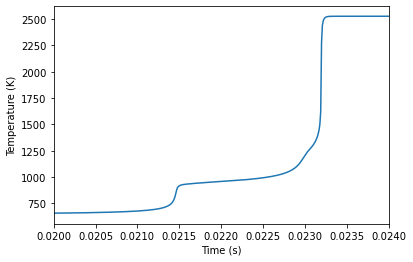

In [5]:
plt.plot(results['time'], results['T'], '-')
plt.xlim((.020, .024))
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

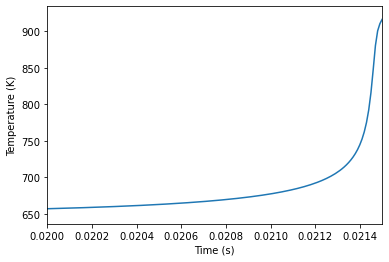

In [6]:
# reset the gas object
gas.TPX = TPX_inlet

# run the simulation again, this time stopping just after 1st-stage ignition
r1 = ct.ConstPressureReactor(gas)
rnet = ct.ReactorNet((r1,))
t_stop = 2.15e-2

results = ud.new_result_dict(gas, ['HO2'])
while rnet.time < t_stop:
    rnet.advance(rnet.time + 1e-5)
    ud.add_to_result(gas, rnet, results)

plt.plot(results['time'], results['T'], '-')
plt.xlim((.020, t_stop))
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

# save the state of the gas - this will be used at the initial state of the "ignited" reactor
TPX_0 = gas.TPX

In [7]:
# Create the perfectly stirred reactor (psr), filled with a mixture consisting of
#   products of first-stage igntion. This state will initialize a radical pool,
#   allowing the contents of the reactor to remain reactive with residence times
#   shorter than the first-stage ignition delay time

gas.TPX = TPX_0
psr = ct.IdealGasReactor(gas)
psr.volume = 1.0


In [8]:
# Create a reservoir for the exhaust. The state of the gas in the exhaust reservoir doesn't matter
exhaust = ct.Reservoir(gas)

# Use a variable mass flow rate to keep the residence time in the reactor
#   constant (residence_time = mass / mass_flow_rate). The mass flow rate function
#   can access variables defined in the calling scope, including state variables
#   of the Reactor object itself.

def mdot(t):
    return psr.mass / residence_time

inlet_mfc = ct.MassFlowController(inlet, psr, mdot=mdot)

In [9]:
# A PressureController has a baseline mass flow rate matching the 'master'
#   MassFlowController, with an additional pressure-dependent term. By explicitly
#   including the upstream mass flow rate, the pressure is kept constant without
#   needing to use a large value for 'K', which can introduce undesired stiffness.
outlet_mfc = ct.PressureController(psr, exhaust, master=inlet_mfc, K=0.01)

In [10]:
t_sim = 0.04  # total time for which to run the simulation
residence_time = 1.0e-3  # residence time used to set the mass flow rate

# initialize the reactor network, containing the one reactor
gas.TPX = TPX_0  # make sure the gas is at the correct initial state
rnet = ct.ReactorNet([psr,])

# set up a dictionary in which to store the results
major_sp = ['NC7H16', 'H2O']
radical_sp = ['OH', 'HO2', 'C7H15O2-1', 'H2O2']

results = ud.new_result_dict(gas, major_sp + radical_sp)

while rnet.time < t_sim:
    rnet.step()
    ud.add_to_result(gas, rnet, results)

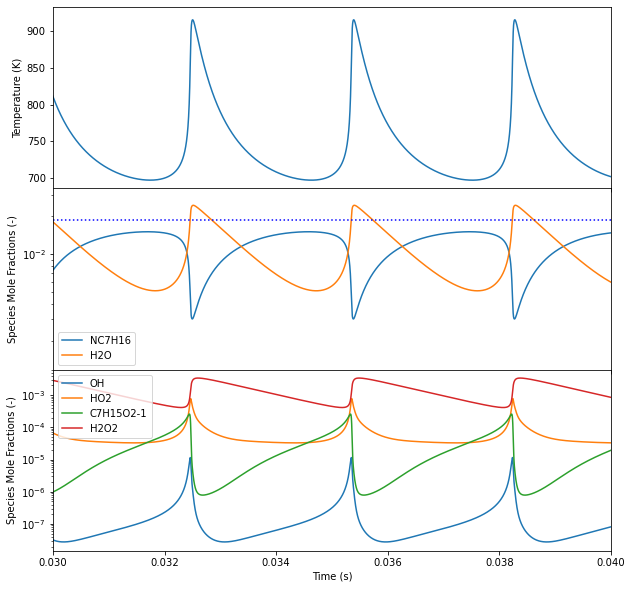

In [11]:
fig, axs = plt.subplots(3, 1, sharex='col', figsize=(10, 10))
plt.subplots_adjust(hspace=0)

plt.sca(axs[0])
plt.plot(results['time'], results['T'], '-')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (K)')

for ax, spcs in zip(axs[1:], [major_sp, radical_sp]):
    plt.sca(ax)
    for sp in spcs:
        plt.semilogy(results['time'], results[sp], '-', label=sp)
    plt.xlabel('Time (s)')
    plt.ylabel('Species Mole Fractions (-)')
    plt.legend()

plt.xlim((.03, .04))

plt.sca(axs[1])
plt.axhline(TPX_inlet[2][gas.species_index(list(fuel.keys())[0])], ls=':', c='b')

At the default conditions, notice how between ignition events:
* The temperature decays from its peak towards the inlet temperature
* The mole fraction of *n*-heptane increases towards the inlet value (dotted line)
* The mole fraction of H2O steadily declines, before rapidly increasing during ignition

With respect to the radical species:
* Hydrogen peroxide (H2O2), like water, decreases steadily between ignition events
* HO2 peaks during ignition, decreasing only slightly in the interval between ignition events
 (you might imagine a quasi-steady-state assumption could apply here)
* OH and C7H15O2-1 (an example of an RO2 species) both *increase* from the time just following
 one ignition event until the time of the next event
